In [1]:
import cv2 
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import string
import pandas as pd
#for building the model
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from tensorflow import keras
from tensorflow.keras import models,layers
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [3]:
# Directory path
df='D:\Resize'

# Directory containing folders with images
root_dir = 'D:\Resize'

# Dictionary to store counts for each folder
folder_counts = {}

# Iterate through each folder in the root directory
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    # Check if the item is a directory
    if os.path.isdir(folder_path):
        # Count the number of image files in the folder
        num_images = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name)) and name.lower().endswith(('.png', '.jpg', '.jpeg'))])
        folder_counts[folder] = num_images

In [4]:
# Extract folder names and corresponding counts
folders = list(folder_counts.keys())
counts = list(folder_counts.values())

In [5]:
# Load data
X=[] #holding data
Y=[] #label

In [6]:
# MATURE
mature_dir = r'D:\Resize\Mature'
mature = os.listdir(mature_dir)

for image_name in mature:
    file_path = os.path.join(mature_dir, image_name)
    image = Image.open(file_path).convert('RGB')
    image = image.resize((64, 64), resample=Image.LANCZOS)  # Changed to LANCZOS for better quality
    X.append(np.array(image).astype('float32') / 255.0)
    Y.append(0)

# IMMATURE
immature_dir = r'D:\Resize\Immature'
immature = os.listdir(immature_dir)

for image_name in immature:
    file_path = os.path.join(immature_dir, image_name)
    image = Image.open(file_path).convert('RGB')
    image = image.resize((64, 64), resample=Image.LANCZOS)  # Changed to LANCZOS for better quality
    X.append(np.array(image).astype('float32') / 255.0)
    Y.append(1)

# NORMAL
normal_dir = r'D:\Resize\Normal'
normal = os.listdir(normal_dir)

for image_name in normal:
    file_path = os.path.join(normal_dir, image_name)
    image = Image.open(file_path).convert('RGB')
    image = image.resize((64, 64), resample=Image.LANCZOS)  # Changed to LANCZOS for better quality
    X.append(np.array(image).astype('float32') / 255.0)
    Y.append(2)

print("Data distribution:", np.unique(Y, return_counts=True))

Data distribution: (array([0, 1, 2]), array([1283, 1125, 1215], dtype=int64))


In [7]:
# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

X shape: (3623, 64, 64, 3)
Y shape: (3623,)


In [8]:
# IMPROVED MODEL ARCHITECTURE
def create_improved_cnn_model():
    model = Sequential([
        # First Block
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Second Block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Third Block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        # Classifier
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.0005)  # Reduced learning rate
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [9]:
# SPLIT DATA INTO TRAIN/VALIDATION/TEST SETS
print("\nSplitting data into train/validation sets...")
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

print(f"Train+Validation samples: {len(X_train_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Test set distribution: {np.unique(y_test, return_counts=True)}")


Splitting data into train/validation sets...
Train+Validation samples: 2898
Test samples: 725
Test set distribution: (array([0, 1, 2]), array([257, 225, 243], dtype=int64))


In [10]:
# K-Fold Cross Validation Setup ONLY on train_val set
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Storage for results
fold_scores = []
fold_histories = []
all_predictions = []
all_true_labels = []

print("\nStarting K-Fold Cross Validation...")
print("="*50)

# K-Fold Cross Validation - ONLY on train_val set
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val, y_train_val)):
    print(f"\nFold {fold + 1}/{k_folds}")
    print("-" * 30)
    
    # Split data for current fold
    x_train_fold, x_val_fold = X_train_val[train_idx], X_train_val[val_idx]
    y_train_fold, y_val_fold = y_train_val[train_idx], y_train_val[val_idx]
    
    # Convert to one-hot encoding
    y_train_fold_cat = to_categorical(y_train_fold, num_classes=3)
    y_val_fold_cat = to_categorical(y_val_fold, num_classes=3)
    
    print(f"Training samples: {len(x_train_fold)}")
    print(f"Validation samples: {len(x_val_fold)}")
    
    # Create and train model
    model = create_improved_cnn_model()
    
    # Improved callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    )
    
    # Train model
    print(f"\nTraining Fold {fold + 1}...")
    history = model.fit(
        x_train_fold, y_train_fold_cat,
        validation_data=(x_val_fold, y_val_fold_cat),
        epochs=100,  # Increased epochs
        batch_size=32,
        shuffle=True,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    # Evaluate model
    val_loss, val_accuracy = model.evaluate(x_val_fold, y_val_fold_cat, verbose=0)
    print(f"\nFold {fold + 1} Results:")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
    
    # Store results
    fold_scores.append({
        'fold': fold + 1,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'epochs_trained': len(history.history['loss'])
    })
    
    fold_histories.append(history.history)
    # Get predictions for this fold
    y_pred_fold = np.argmax(model.predict(x_val_fold, verbose=0), axis=1)
    all_predictions.extend(y_pred_fold)
    all_true_labels.extend(y_val_fold)

print("\n" + "="*50)
print("K-FOLD CROSS VALIDATION SUMMARY")
print("="*50)


Starting K-Fold Cross Validation...

Fold 1/5
------------------------------
Training samples: 2318
Validation samples: 580

Training Fold 1...
Epoch 1/100
73/73 [==============================] - 7s 19ms/step - loss: 1.4602 - accuracy: 0.5302 - val_loss: 2.4660 - val_accuracy: 0.3534 - lr: 5.0000e-04
Epoch 2/100
73/73 [==============================] - 1s 12ms/step - loss: 0.9029 - accuracy: 0.6609 - val_loss: 4.2048 - val_accuracy: 0.3534 - lr: 5.0000e-04
Epoch 3/100
73/73 [==============================] - 1s 11ms/step - loss: 0.6110 - accuracy: 0.7662 - val_loss: 3.1921 - val_accuracy: 0.3534 - lr: 5.0000e-04
Epoch 4/100
73/73 [==============================] - 1s 11ms/step - loss: 0.4478 - accuracy: 0.8335 - val_loss: 3.0204 - val_accuracy: 0.4914 - lr: 5.0000e-04
Epoch 5/100
73/73 [==============================] - 1s 11ms/step - loss: 0.3054 - accuracy: 0.8887 - val_loss: 3.3493 - val_accuracy: 0.5621 - lr: 5.0000e-04
Epoch 6/100
73/73 [==============================] - 1s 11ms

In [11]:
# Buat DataFrame dari hasil fold
results_df = pd.DataFrame(fold_scores)
print("\nDetailed Results per Fold:")
print(results_df.to_string(index=False))

# Hitung statistik summary
mean_accuracy = results_df['val_accuracy'].mean()
std_accuracy = results_df['val_accuracy'].std()
mean_loss = results_df['val_loss'].mean()
std_loss = results_df['val_loss'].std()

print(f"\n" + "="*50)
print("STATISTICAL SUMMARY")
print("="*50)
print(f"• Average Validation Accuracy: {mean_accuracy*100:.2f}% ± {std_accuracy*100:.2f}%")
print(f"• Average Validation Loss: {mean_loss:.4f} ± {std_loss:.4f}")
print(f"• Best Fold Accuracy: {results_df['val_accuracy'].max()*100:.2f}%")
print(f"• Worst Fold Accuracy: {results_df['val_accuracy'].min()*100:.2f}%")
print(f"• Accuracy Range: {(results_df['val_accuracy'].max() - results_df['val_accuracy'].min())*100:.2f}%")



Detailed Results per Fold:
 fold  val_loss  val_accuracy  epochs_trained
    1  0.000784      1.000000              57
    2  0.001580      1.000000              58
    3  0.010813      0.998276              43
    4  0.002769      0.998273              51
    5  0.000875      1.000000             100

STATISTICAL SUMMARY
• Average Validation Accuracy: 99.93% ± 0.09%
• Average Validation Loss: 0.0034 ± 0.0042
• Best Fold Accuracy: 100.00%
• Worst Fold Accuracy: 99.83%
• Accuracy Range: 0.17%


In [12]:
# Overall Classification Report
disease_labels = ['Mature', 'Immature', 'Normal']
print("\n" + "="*50)
print("OVERALL CLASSIFICATION PERFORMANCE")
print("="*50)

print("\nClassification Report (All Folds Combined):")
print(classification_report(all_true_labels, all_predictions, 
                          target_names=disease_labels, digits=4))


OVERALL CLASSIFICATION PERFORMANCE

Classification Report (All Folds Combined):
              precision    recall  f1-score   support

      Mature     0.9990    0.9990    0.9990      1026
    Immature     0.9989    0.9989    0.9989       900
      Normal     1.0000    1.0000    1.0000       972

    accuracy                         0.9993      2898
   macro avg     0.9993    0.9993    0.9993      2898
weighted avg     0.9993    0.9993    0.9993      2898




Confusion Matrix:
[[1025    1    0]
 [   1  899    0]
 [   0    0  972]]


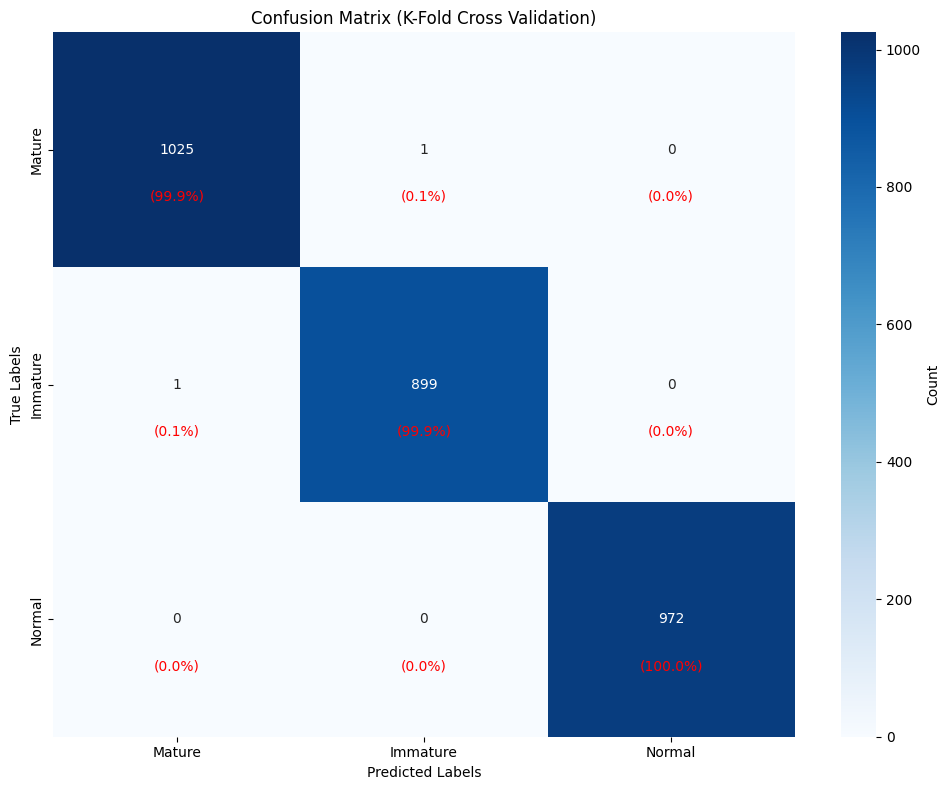


K-FOLD CROSS VALIDATION COMPLETED!


In [13]:
# Confusion Matrix
cm = confusion_matrix(all_true_labels, all_predictions)
print(f"\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=disease_labels, yticklabels=disease_labels,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (K-Fold Cross Validation)')

# Add percentages
for i in range(len(disease_labels)):
    for j in range(len(disease_labels)):
        percentage = cm[i, j] / cm[i].sum() * 100
        plt.text(j+0.5, i+0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("K-FOLD CROSS VALIDATION COMPLETED!")
print("="*50)


In [14]:
# Summary
print(f"\nSUMMARY:")
print(f"• Dataset size: {len(X_train_val)} images (training + validation)")
print(f"• Test set size: {len(X_test)} images (held out)")
print(f"• Cross-validation folds: {k_folds}")
print(f"• Average accuracy: {mean_accuracy*100:.2f}% ± {std_accuracy*100:.2f}%")
print(f"• Best fold: Fold {results_df.loc[results_df['val_accuracy'].idxmax(), 'fold']} ({results_df['val_accuracy'].max()*100:.2f}%)")
print(f"• Worst fold: Fold {results_df.loc[results_df['val_accuracy'].idxmin(), 'fold']} ({results_df['val_accuracy'].min()*100:.2f}%)")
print(f"• Model stability: {'Good' if std_accuracy < 0.02 else 'Moderate' if std_accuracy < 0.05 else 'Poor'}")

# TRAIN FINAL MODEL ON TRAIN_VAL SET (NOT WHOLE DATASET)
print(f"\n" + "="*60)
print("TRAINING FINAL MODEL ON TRAIN+VALIDATION SET")
print("="*60)


SUMMARY:
• Dataset size: 2898 images (training + validation)
• Test set size: 725 images (held out)
• Cross-validation folds: 5
• Average accuracy: 99.93% ± 0.09%
• Best fold: Fold 1 (100.00%)
• Worst fold: Fold 4 (99.83%)
• Model stability: Good

TRAINING FINAL MODEL ON TRAIN+VALIDATION SET


In [15]:
# Convert labels to one-hot encoding
y_train_val_cat = to_categorical(y_train_val, num_classes=3)

print(f"Training final model with train+validation set:")
print(f"• Training samples: {len(X_train_val)}")
print(f"• Test samples (held out): {len(X_test)}")
print(f"• Image shape: {X_train_val.shape[1:]}")
print(f"• Classes: {len(np.unique(y_train_val))}")

Training final model with train+validation set:
• Training samples: 2898
• Test samples (held out): 725
• Image shape: (64, 64, 3)
• Classes: 3


In [16]:
# Create final model
print(f"\nCreating final model...")
final_model = create_improved_cnn_model()

# Setup callbacks
final_early_stop = EarlyStopping(
    monitor='loss',
    patience=20,
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

print(f"\nStarting final training...")
print(f"Note: Using train+validation set, keeping test set completely separate")

# Train final model
final_history = final_model.fit(
    X_train_val, y_train_val_cat,
    epochs=50,
    batch_size=32,
    shuffle=True,
    callbacks=[final_early_stop, reduce_lr],
    verbose=1
)

print(f"\n" + "="*60)
print("FINAL TRAINING COMPLETED!")
print("="*60)



Creating final model...

Starting final training...
Note: Using train+validation set, keeping test set completely separate
Epoch 1/50
91/91 [==============================] - 2s 13ms/step - loss: 1.5501 - accuracy: 0.5090 - lr: 5.0000e-04
Epoch 2/50
91/91 [==============================] - 1s 11ms/step - loss: 0.8774 - accuracy: 0.7063 - lr: 5.0000e-04
Epoch 3/50
91/91 [==============================] - 1s 11ms/step - loss: 0.4558 - accuracy: 0.8240 - lr: 5.0000e-04
Epoch 4/50
91/91 [==============================] - 1s 11ms/step - loss: 0.3463 - accuracy: 0.8682 - lr: 5.0000e-04
Epoch 5/50
91/91 [==============================] - 1s 11ms/step - loss: 0.2366 - accuracy: 0.9117 - lr: 5.0000e-04
Epoch 6/50
91/91 [==============================] - 1s 11ms/step - loss: 0.1698 - accuracy: 0.9358 - lr: 5.0000e-04
Epoch 7/50
91/91 [==============================] - 1s 11ms/step - loss: 0.1242 - accuracy: 0.9569 - lr: 5.0000e-04
Epoch 8/50
91/91 [==============================] - 1s 11ms/step

In [17]:
# EVALUATE ON UNSEEN TEST SET
print(f"\n" + "="*60)
print("EVALUATING ON UNSEEN TEST SET")
print("="*60)

y_test_cat = to_categorical(y_test, num_classes=3)
test_loss, test_accuracy = final_model.evaluate(X_test, y_test_cat, verbose=0)

print(f"Test Set Results:")
print(f"• Test Loss: {test_loss:.4f}")
print(f"• Test Accuracy: {test_accuracy*100:.2f}%")


EVALUATING ON UNSEEN TEST SET
Test Set Results:
• Test Loss: 0.0054
• Test Accuracy: 99.72%


In [18]:
# Compare with K-Fold results
print(f"\nComparison with K-Fold Results:")
print(f"• K-Fold average accuracy: {mean_accuracy*100:.2f}% ± {std_accuracy*100:.2f}%")
print(f"• Test set accuracy: {test_accuracy*100:.2f}%")



Comparison with K-Fold Results:
• K-Fold average accuracy: 99.93% ± 0.09%
• Test set accuracy: 99.72%



Test Set Classification Report:
              precision    recall  f1-score   support

      Mature     1.0000    0.9961    0.9981       257
    Immature     1.0000    0.9956    0.9978       225
      Normal     0.9918    1.0000    0.9959       243

    accuracy                         0.9972       725
   macro avg     0.9973    0.9972    0.9972       725
weighted avg     0.9973    0.9972    0.9972       725



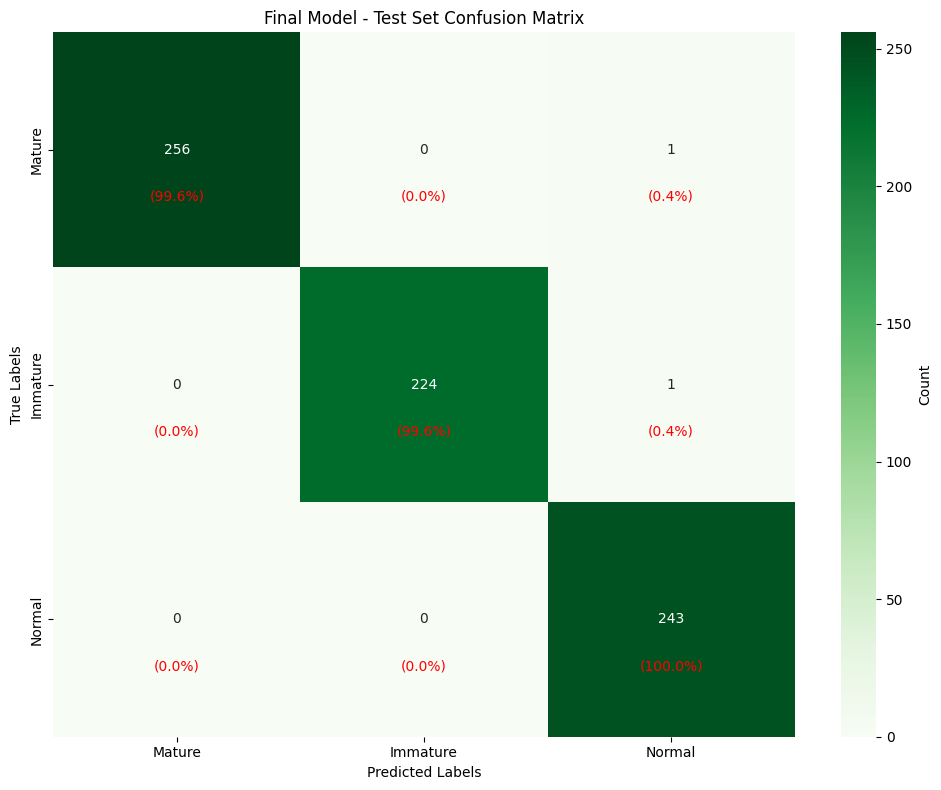

In [19]:
# Test set predictions
test_predictions = np.argmax(final_model.predict(X_test, verbose=0), axis=1)

print(f"\nTest Set Classification Report:")
print(classification_report(y_test, test_predictions, 
                          target_names=disease_labels, digits=4))

# Test set confusion matrix
test_cm = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=disease_labels, yticklabels=disease_labels,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Final Model - Test Set Confusion Matrix')

for i in range(len(disease_labels)):
    for j in range(len(disease_labels)):
        percentage = test_cm[i, j] / test_cm[i].sum() * 100
        plt.text(j+0.5, i+0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

In [20]:
# Save final model
print(f"\n" + "="*60)
print("SAVING FINAL MODEL")
print("="*60)

model_save_path = 'final_improved_cataract_model'
final_model.save(model_save_path)
print(f"✅ Final model saved to: {model_save_path}")

print(f"\n" + "="*60)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"Key improvements made:")
print(f"• Removed final training on complete dataset (prevents overfitting)")
print(f"• Added separate test set for unbiased evaluation")
print(f"• Improved model architecture with BatchNormalization")
print(f"• Better regularization with appropriate Dropout")
print(f"• Improved image preprocessing (LANCZOS resampling)")
print(f"• Better learning rate scheduling")
print(f"• Test accuracy: {test_accuracy*100:.2f}% (true performance on unseen data)")


SAVING FINAL MODEL


INFO:tensorflow:Assets written to: final_improved_cataract_model\assets


INFO:tensorflow:Assets written to: final_improved_cataract_model\assets


✅ Final model saved to: final_improved_cataract_model

TRAINING COMPLETED SUCCESSFULLY!
Key improvements made:
• Removed final training on complete dataset (prevents overfitting)
• Added separate test set for unbiased evaluation
• Improved model architecture with BatchNormalization
• Better regularization with appropriate Dropout
• Improved image preprocessing (LANCZOS resampling)
• Better learning rate scheduling
• Test accuracy: 99.72% (true performance on unseen data)


In [21]:
def preprocess_image(image_path):
    """Preprocess image untuk prediksi (sama seperti training)"""
    try:
        # Load dan convert ke RGB
        image = Image.open(image_path).convert('RGB')
        
        # Resize ke ukuran yang sama dengan training (64x64)
        image = image.resize((64, 64), resample=Image.LANCZOS)
        
        # Convert ke numpy array dan normalize
        image_array = np.array(image).astype('float32') / 255.0
        
        # Add batch dimension (model expects batch)
        image_array = np.expand_dims(image_array, axis=0)
        
        return image_array, image  # Return processed array + original for display
        
    except Exception as e:
        print(f"❌ Error preprocessing image: {e}")
        return None, None

def predict_single_image(model, image_path, class_names=['Mature', 'Immature', 'Normal']):
    """Prediksi untuk satu gambar"""
    
    # Preprocess image
    processed_image, original_image = preprocess_image(image_path)
    
    if processed_image is None:
        return None
    
    # Predict
    predictions = model.predict(processed_image, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    
    # Get all class probabilities
    class_probabilities = {
        class_names[i]: predictions[0][i] * 100 
        for i in range(len(class_names))
    }
    
    result = {
        'predicted_class': class_names[predicted_class_idx],
        'confidence': confidence * 100,
        'all_probabilities': class_probabilities,
        'image': original_image
    }
    
    return result

In [34]:
def test_single_image_auto(image_path):
    """Prediksi otomatis untuk satu gambar tanpa input manual"""
    print(f"\n" + "="*60)
    print("🔍 PREDIKSI OTOMATIS - GAMBAR BARU")
    print("="*60)

    class_names = ['Mature', 'Immature', 'Normal']

    if not os.path.exists(image_path):
        print(f"❌ File tidak ditemukan: {image_path}")
        return

    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')
    if not image_path.lower().endswith(valid_extensions):
        print(f"❌ File bukan gambar valid. Format yang didukung: {valid_extensions}")
        return

    print(f"\n🔄 Memproses gambar: {os.path.basename(image_path)}")
    
    # Predict
    result = predict_single_image(final_model, image_path, class_names)

    if result is None:
        print("❌ Gagal memproses gambar")
        return

    # Display results
    print(f"\n" + "="*40)
    print("📊 HASIL PREDIKSI")
    print("="*40)
    print(f"🎯 Prediksi: {result['predicted_class']}")
    print(f"💪 Confidence: {result['confidence']:.2f}%")
    
    print(f"\n📈 Detail probabilitas:")
    for class_name, prob in result['all_probabilities'].items():
        bar_length = int(prob / 5)
        bar = "█" * bar_length + "░" * (20 - bar_length)
        print(f"   {class_name:10}: {prob:6.2f}% {bar}")
    
    print(f"\n🔍 Interpretasi:")
    if result['confidence'] >= 80:
        print(f"   ✅ Prediksi sangat yakin ({result['confidence']:.1f}%)")
    elif result['confidence'] >= 60:
        print(f"   ⚡ Prediksi cukup yakin ({result['confidence']:.1f}%)")
    else:
        print(f"   ⚠️ Prediksi kurang yakin ({result['confidence']:.1f}%) - mungkin gambar ambiguous")
    
    try:
        img_info = Image.open(image_path)
        print(f"\n📸 Info gambar:")
        print(f"   Ukuran asli: {img_info.size}")
        print(f"   Mode: {img_info.mode}")
        print(f"   Format: {img_info.format}")
    except:
        pass

# Jalankan untuk gambar tertentu
test_single_image_auto(r'D:\Download\matamamah.jpg')



🔍 PREDIKSI OTOMATIS - GAMBAR BARU

🔄 Memproses gambar: matamamah.jpg

📊 HASIL PREDIKSI
🎯 Prediksi: Normal
💪 Confidence: 100.00%

📈 Detail probabilitas:
   Mature    :   0.00% ░░░░░░░░░░░░░░░░░░░░
   Immature  :   0.00% ░░░░░░░░░░░░░░░░░░░░
   Normal    : 100.00% ███████████████████░

🔍 Interpretasi:
   ✅ Prediksi sangat yakin (100.0%)

📸 Info gambar:
   Ukuran asli: (696, 552)
   Mode: RGB
   Format: JPEG


In [23]:
#model.save('saved_model_cataract4')  # Folder akan dibuat